In [2]:
import praw
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import json
import numpy as np
from tkinter import ttk, messagebox, font
from PIL import Image, ImageTk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from textblob import TextBlob


In [3]:
# 下载所需的nltk资源
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\86138\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\86138\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
reddit = praw.Reddit(
    client_id='ySUBd0IU8CQ8rTtpTt3yZg',
    client_secret='3vzNl5FDkvg8IrRDMPryQnX3yK4hfw',
    user_agent='web:Alex:v1.0 (by /u/Far_Possibility7465)'
)


In [5]:

stop_words = set(stopwords.words('english'))

def normalized_sentence(sentence):
    # Normalization helper functions
    def lower_case(text):
        return text.lower()

    def removing_numbers(text):
        return ''.join(char for char in text if not char.isdigit())

    def removing_punctuations(text):
        punctuations = """!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
        modified_punctuations = punctuations.replace("!", "").replace("?", "")
        return re.sub(r'[' + re.escape(modified_punctuations) + ']', ' ', text).strip()

    def removing_urls(text):
        return re.sub(r'https?://\S+|www\.\S+', '', text)

    def remove_stop_words(text):
        return " ".join(word for word in text.split() if word.lower() not in stop_words)

    def lemmatization(text):
        lemmatizer = WordNetLemmatizer()
        return " ".join(lemmatizer.lemmatize(word) for word in text.split())

    # Apply normalization process
    sentence = lower_case(sentence)
    sentence = removing_numbers(sentence)
    sentence = removing_punctuations(sentence)
    sentence = removing_urls(sentence)
    sentence = remove_stop_words(sentence)
    sentence = lemmatization(sentence)
    return sentence

In [6]:
def get_comments(keyword):
    posts = reddit.subreddit('all').search(keyword, limit=5)
    comments_list = []
    for post in posts:
        post.comments.replace_more(limit=0)
        for comment in post.comments.list()[:10]:
            clean_comment = normalized_sentence(comment.body)
            comments_list.append(clean_comment)
    return comments_list

In [15]:
keyword = input("Enter a keyword: ")
comments = get_comments(keyword)

Enter a keyword:  I am a good student


In [25]:
print(comments)

['yes wrong name favorite', '“my favorite student wouldn’t ask”', 'know you?', 'always say top', 'yes every kid ever asked', 'depends snarky feel like depends favorite teacher? favorite hate equally icily mock confusion you?', 'always say know favorite give wink little smile take mean favorite get away scot free', 'favorite class always say st period try figure one slowly dawn it’s prep', 'deleted', 'deleted', 'hey everyone keep mind personal opinion post reflect everyones view r teacher mod team neither endorses condemns perspective please civil report rule breaker', 'inclusion without support abandonment', 'what’s equal nobody receiving need?', 'left teaching kid need help getting help need kid well get education interrupted daily kid need help serious note anyone idea something could actually this? i’ve thought looking policy research job don’t want turn one pd people haven’t stepped inside classroom year trying “train” teacher', 'big qualm done feeling nuance kid used special day c

In [26]:

model_path = r"C:/Users/86138/Desktop/A/ML_Group1/Tweets/Group1/Code/transformer_classification_model.h5"

In [27]:
def load_model_and_components():
    # 载入模型
    model = tf.keras.models.load_model(model_path)
    
    # 载入 tokenizer 配置
    with open("tokenizer_config.json", "r") as tokenizer_file:
        word_index = json.load(tokenizer_file)
    
    tokenizer = Tokenizer(num_words=100000, oov_token="<OOV>")
    tokenizer.word_index = word_index  # 手动恢复 word_index
    
    # 载入 Label Encoder 配置
    label_classes = np.load("label_classes.npy", allow_pickle=True)
    label_encoder = LabelEncoder()
    label_encoder.classes_ = label_classes
    
    return model, tokenizer, label_encoder

def prepare_data(new_texts, tokenizer, max_len):
    new_sequences = tokenizer.texts_to_sequences(new_texts)
    new_padded = pad_sequences(new_sequences, maxlen=max_len)
    return new_padded

def make_prediction(model, prepared_data):
    return model.predict(prepared_data)

def interpret_predictions(predictions, label_encoder):
    # Define mappings from emotion labels to categories
    '''emotion_to_category = {
        "fear": "Negative",
        "sadness": "Negative",
        "anger": "Negative",
        "neutral": "Neutral",
        "joy": "Positive",
        "love": "Positive",
        "surprise": "Positive",
        "happiness": "Positive"
    }'''

    # Predict the classes
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels = label_encoder.inverse_transform(predicted_classes)

    # Map labels to categories
    #predicted_categories = [emotion_to_category.get(label, "Unknown") for label in predicted_labels]
    #return predicted_categories

    return predicted_labels

def predict_new_texts(model, tokenizer, new_texts, max_len, label_encoder):
    prepared_data = prepare_data(new_texts, tokenizer, max_len)
    predictions = make_prediction(model, prepared_data)
    return interpret_predictions(predictions, label_encoder)

In [28]:
# 用法示例
model, tokenizer, label_encoder = load_model_and_components()

In [29]:
max_len = 100

y_pred = predict_new_texts(model, tokenizer, comments, max_len, label_encoder)

print(y_pred)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024F2BA6E660> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
['neutral' 'joy' 'neutral' 'neutral' 'neutral' 'anger' 'joy' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'sadness' 'happiness'
 'happiness' 'sadness' 'sadness' 'sadness' 'sadness' 'love' 'fear' 'love'
 'anger' 'sadness' 'fear' 'sadness' 'sadness' 'surprise' 'sadness' 'anger'
 'joy' 'sadness' 'joy' 'sadness' 'fear' 'neutral' 'fear' 'fear' 'fear'
 'fear' 'joy' 'neutral' 'joy' 'joy' 'neutral' 'joy' 'neutral' 'joy'
 'neutral']


neutral: 15
joy: 9
anger: 3
sadness: 11
happiness: 2
love: 2
fear: 7
surprise: 1


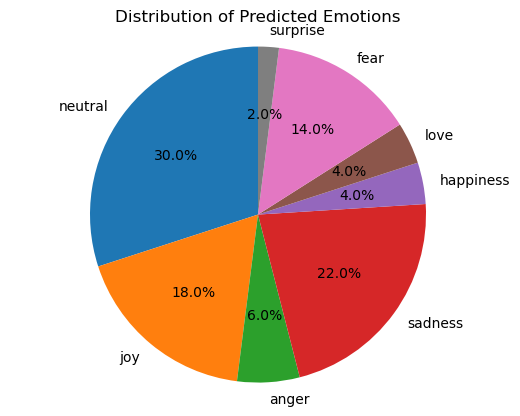

In [30]:
# 使用Counter来计算每种情绪的出现次数
emotion_counts = Counter(y_pred)

# 打印每种情绪及其计数
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")

# 创建饼图
fig, ax = plt.subplots()
ax.pie(emotion_counts.values(), labels=emotion_counts.keys(), autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # 确保饼图是圆形
plt.title('Distribution of Predicted Emotions')
plt.show()

# Using TextBlob

In [31]:
emotions = []
# 分析每条评论并根据极性得分分配情绪标签
for comment in comments:
    blob = TextBlob(comment)
    polarity = blob.sentiment.polarity
    if polarity > 0.05:  # 假设极性大于0.1为正面
        emotions.append('Positive')
    elif polarity < -0.05:  # 假设极性小于-0.1为负面
        emotions.append('Negative')
    else:
        emotions.append('neutral')  # 其他情况视为中性

# 输出情绪列表
print(emotions)

['neutral', 'Positive', 'neutral', 'Positive', 'neutral', 'neutral', 'Positive', 'Positive', 'neutral', 'neutral', 'Positive', 'neutral', 'neutral', 'Negative', 'neutral', 'neutral', 'neutral', 'neutral', 'Negative', 'Negative', 'neutral', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Positive', 'Negative', 'neutral', 'Positive', 'Negative', 'neutral', 'Negative', 'neutral', 'neutral', 'Negative', 'Positive', 'Positive', 'neutral', 'neutral', 'Positive', 'Positive', 'neutral', 'Positive', 'neutral', 'neutral', 'Negative']


neutral: 22
Positive: 17
Negative: 11


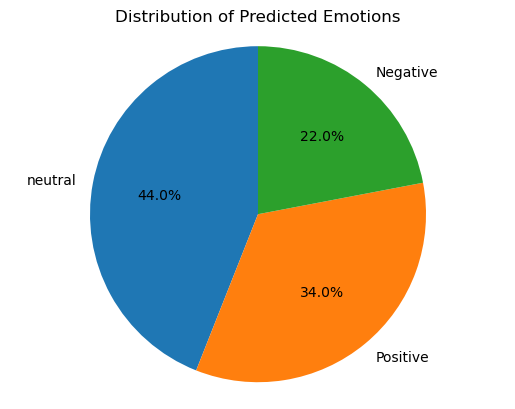

In [32]:
# 使用Counter来计算每种情绪的出现次数
emotion_counts = Counter(emotions)

# 打印每种情绪及其计数
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")

# 创建饼图
fig, ax = plt.subplots()
ax.pie(emotion_counts.values(), labels=emotion_counts.keys(), autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # 确保饼图是圆形
plt.title('Distribution of Predicted Emotions')
plt.show()

In [33]:
model, tokenizer, label_encoder = load_model_and_components()

# UI

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step 


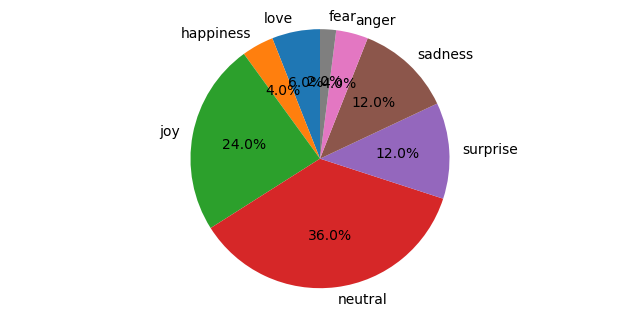

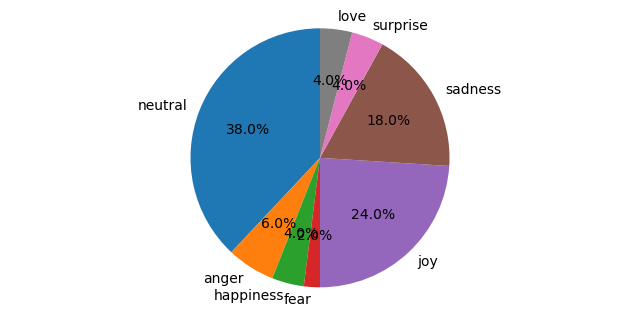

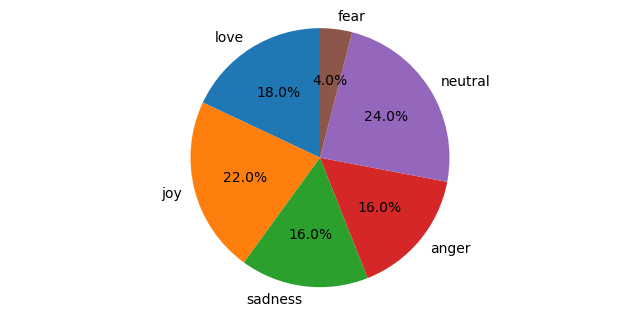

In [35]:
import tkinter as tk
from tkinter import ttk, messagebox, font
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from collections import Counter

# 以下是假设已定义的函数
# please ensure that your normalized_sentence, get_comments, predict_new_texts, load_model_and_components functions are defined here

def fetch_and_predict(keyword):
    try:
        comments = get_comments(keyword)  # Fetch comments using Reddit API
        #model, tokenizer, label_encoder = load_model_and_components()  # Load model and components
        max_len = 100  # This should match with the model setup
        emotion_predictions = predict_new_texts(model, tokenizer, comments, max_len, label_encoder)
        return emotion_predictions
    except Exception as e:
        messagebox.showerror("Error", str(e))
        return []

def display_chart(frame, predictions):
    for widget in frame.winfo_children():
        widget.destroy()
    if predictions.any():  # Use .any() if predictions is a numpy array and not empty
        emotion_counts = Counter(predictions)
        fig, ax = plt.subplots()
        ax.pie(emotion_counts.values(), labels=emotion_counts.keys(), autopct='%1.1f%%', startangle=90)
        ax.axis('equal')  # Ensure the pie chart is drawn as a circle.
        canvas = FigureCanvasTkAgg(fig, master=frame)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack(fill=tk.BOTH, expand=True)
        canvas.draw()

def on_submit():
    keyword = entry_keyword.get()
    if keyword:
        predictions = fetch_and_predict(keyword)
        display_chart(chart_frame, predictions)

def setup_background(root, image_path):
    """Setup the background image for the application."""
    global background_photo  # Keep a reference to avoid garbage collection
    image = Image.open(image_path)
    background_photo = ImageTk.PhotoImage(image)
    background_label = tk.Label(root, image=background_photo)
    background_label.place(x=0, y=0, relwidth=1, relheight=1)

# Initialize the main application window
root = tk.Tk()
root.title("Reddit Emotion Analyzer")
root.geometry("800x600")

# Configure style for the widgets
style = ttk.Style()
style.configure("Large.TButton", font=('Helvetica', 14))

# Setup the background
setup_background(root, "C:/Users/86138/Desktop/A/Weixin Image_20231126133625.png")

# Entry widget for keyword input
entry_keyword = ttk.Entry(root, font=('Helvetica', 14), width=50)
entry_keyword.pack(pady=(50, 10))

# Button to trigger emotion analysis
submit_button = ttk.Button(root, text="Analyze Emotion", style="Large.TButton", command=on_submit)
submit_button.pack(pady=(10, 100))

# Frame for displaying the results
chart_frame = tk.Frame(root)
chart_frame.pack(fill=tk.BOTH, expand=True)

# Start the application loop
root.mainloop()